In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import unit_impulse,fftconvolve,freqz, butter, residue, freqs
from numpy.lib.scimath import sqrt as csqrt
from scipy.special import iv
from scipy.fft import fft, fftfreq
pi = np.pi

## Project of a low-pass IIR filter by Impulse Invariance with a Butterworth Filter

In [3]:
def x(t): ## signal to be filtered
    y = np.cos(2*pi*60*t) + 2*np.cos(2*pi*600*t)
    return y

In [5]:
def H(A, poles, omega): ## returns the system function of the discrete time filter by the impulse invariance method
    j = csqrt(-1)
    N = len(poles) ## 'poles' are the poles of the transfer function of the continuous time filter
    response = np.zeros(len(omega), dtype = 'complex')
    for i in range(len(omega)):
        parcel = 0
        for k in range(N):
            parcel = parcel + (A[k])/(1 - np.exp(-j*omega[i] + poles[k])) ## Z = exp(j*omega)
        response[i] = parcel
    return response

In [6]:
def Fourier(omega, h): ## Discrete Time Fourier Transform DTFT
    H = np.zeros(len(omega), dtype = 'complex')
    j = csqrt(-1)
    for i in range(len(omega)):
        parcel = 0
        for k in range(len(h)):
            parcel = parcel + h[k]*np.exp(-j*omega[i]*k)
        H[i] = parcel
    return H

## Filter Specifications

Text(0.5, 1.0, 'log magnitude')

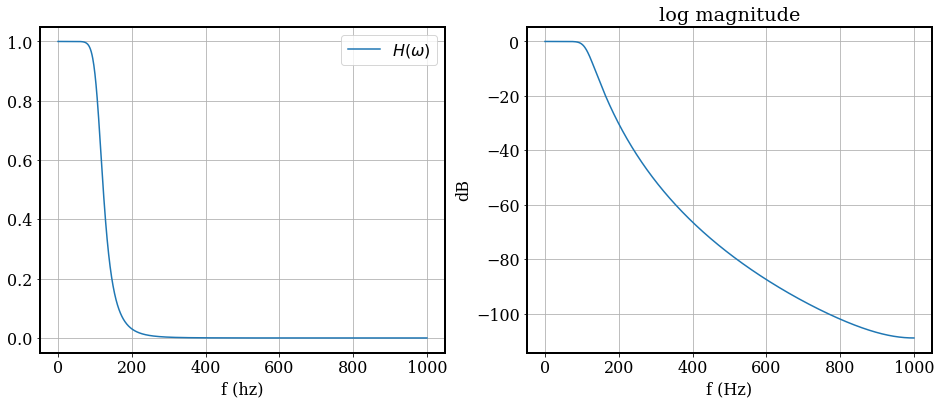

In [7]:
fs = 2000 ##Sampling rate
T = 1/fs
Omega_s = 2*pi*400 ## stop frequency
Omega_p = 2*pi*100 ## pass frequency
ws = Omega_s*T ## normalized frequency, omega = 2*pi*f*T, where T is the inverse of the sampling rate
wp = Omega_p*T

delta1 = 1 #dB ## maximum attneuation in the pass band
delta2 = 60 #dB ## mimimum attenuation in the stop band
atp = 10**(-delta1/20)
ats = 10**(-delta2/20)

order = np.log10((1/atp**2 - 1)/(1/ats**2 - 1))*1/(2*np.log10(Omega_p/Omega_s)) ## calculating the order of the filter
N = int(order) + 1 ## ther order must be an integer
Omega_c = wp*((1/atp**2 - 1)**(-0.5/N)) ## calculating Omega_c with the integer value of N

Hc = butter(N, Omega_c, btype = 'low',analog = 'True', output = 'ba') ## returning the transfer function of the continuous time Butterworth filter
Apart = residue(Hc[0], Hc[1]) ##  partial fraction expansion
Ak = Apart[0] ## numerators of the partial fraction expansion
sk = Apart[1] ## poles of the transfer function

freq = np.linspace(0, np.pi, 1000)
Hw = H(Ak, sk, freq) ## impulse response of the discrete time filter in the frequency domain by impulse invariance

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16} 
plt.rc('font', **font)
plt.rc('axes', linewidth=2)

figure, ax = plt.subplots(1,2,figsize = (16, 6))

ax[0].plot(freq/(2*np.pi*T), abs(Hw), label = '$H(\omega)$')
ax[0].grid(True)
ax[0].set_xlabel('f (hz)')
ax[0].legend(loc = 'upper right')

ax[1].plot(freq/(2*pi*T), 20*np.log10(abs(Hw)))
ax[1].grid(True)
ax[1].set_xlabel('f (Hz)')
ax[1].set_ylabel('dB')
ax[1].set_title('log magnitude')


## Filtering the Signal

C:\Users\moise\AppData\Local\Temp\ipykernel_69936\1735804964.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  yn[i] = 1/(pi)*np.trapz((Yw)*np.exp(j*freq*n[i]), freq, pi/1000) ##Inverse Discrete Time Fourier Transform


Text(0.5, 1.0, '$|Y(\\omega)|$, filtered signal')

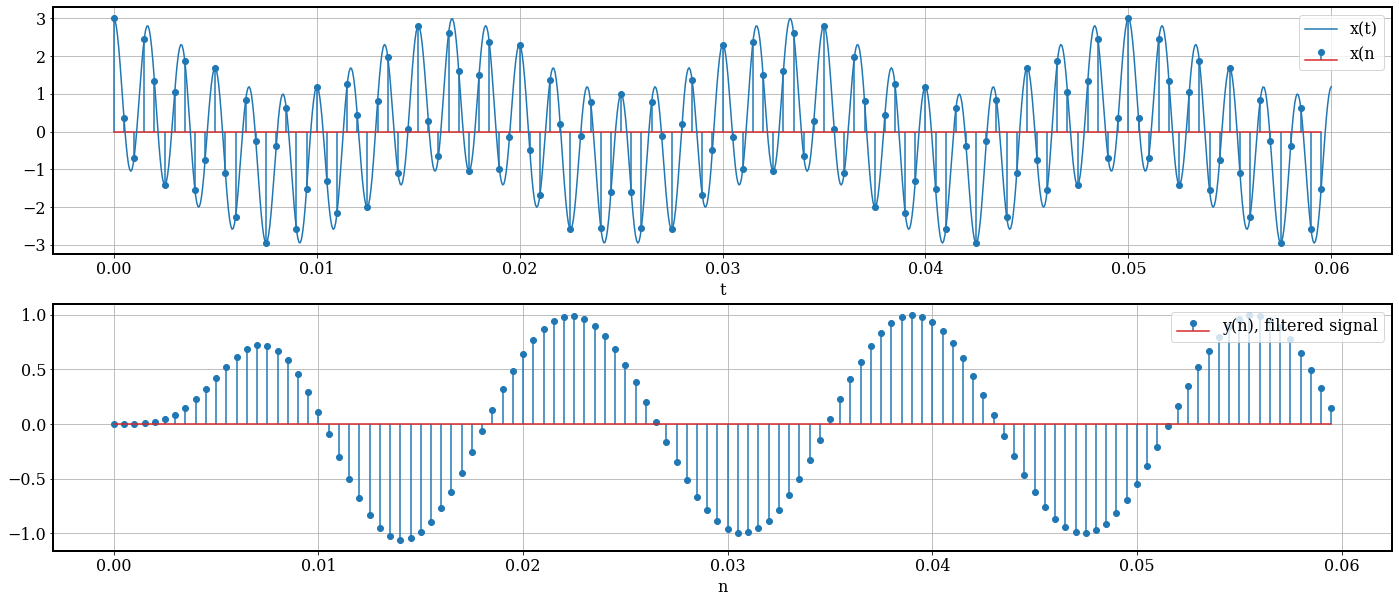

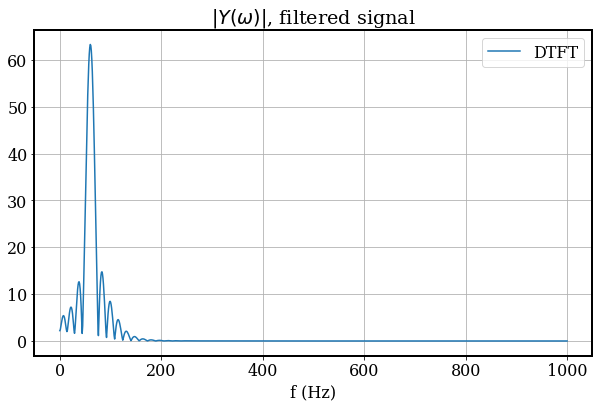

In [11]:
lim = 0.06
Samples = lim/T
t = np.linspace(0, lim, 1000)
k = np.arange(Samples)*T ## sampling the signal with sample rate 1/T

Xw = Fourier(freq, x(k)) ## Fourier Trnasform of x(t)
Yw = Xw*Hw ## Y(w) = x(w)*H(w), output signal

j = csqrt(-1)
yn = np.zeros(int(Samples)) ## Outtput signal
n = np.arange(int(Samples))
for i in range(len(n)):
    yn[i] = 1/(pi)*np.trapz((Yw)*np.exp(j*freq*n[i]), freq, pi/1000) ##Inverse Discrete Time Fourier Transform

figure, ax = plt.subplots(2, 1, figsize = (24, 10))

ax[0].stem(k, x(k), label = 'x(n')
ax[0].plot(t, x(t), label = 'x(t)')
ax[0].grid(True)
ax[0].set_xlabel('t')
ax[0].legend(loc = 'upper right')

ax[1].stem(k, yn, label = 'y(n), filtered signal')
ax[1].grid(True)
ax[1].set_xlabel('n')
ax[1].legend(loc = 'upper right')

figure = plt.figure(figsize = (10,6))

plt.plot(freq/(2*pi*T), abs(Yw), label = 'DTFT')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.xlabel('f (Hz)')
plt.title('$|Y(\omega)|$' + ', filtered signal')